# Supplemental Code for _Representational Rényi Heterogeneity_

__Abraham Nunes__. _Department of Psychiatry & Faculty of Computer Science, Dalhousie University_  
__Martin Alda__. _Department of Psychiatry, Dalhousie University_  
__Timothy Bardouille__. _Department of Physics & Atmospheric Sciences, Dalhousie University_  
__Thomas Trappenberg__. _Faculty of Computer Science, Dalhousie University_


In [1]:
import os
import urllib
import numpy as np 
import mpmath as mp
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torchvision.utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import scipy.stats as ss
from scipy.special import gamma, beta
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
matplotlib.rcParams.update({'font.size': 12, 
                            'font.family': "serif"})
use_gpu = True

# INSTALL & IMPORT DIVERSITY PACKAGE
!pip3 install --ignore-installed git+https://github.com/abrahamnunes/diversity.git
import diversity as div


# Define the regularized incomplete beta function 
#   Using similar syntax as mathematica
def BetaRegularized(z0, z1, a, b, reg=True):
    if np.ndim(z0)==0:
        out = mp.betainc(a, b, z0, z1, regularized=reg)
    else: 
        out = np.array([
                mp.betainc(a, b, z_, z1, regularized=reg) for z_ in z0])
    return out

# Vectorized functions for mpmath
mplog = np.vectorize(mp.log)
mpexp = np.vectorize(mp.exp)

  Cloning https://github.com/abrahamnunes/diversity.git to /tmp/pip-req-build-qllvy6_x
  Running command git clone -q https://github.com/abrahamnunes/diversity.git /tmp/pip-req-build-qllvy6_x
  Created wheel for diversity: filename=diversity-0.1.0-py2.py3-none-any.whl size=13960 sha256=f98fdd86d56abf69480b80022419b1618f3e5db0e9266fb41ebabf0b30be5d83
  Stored in directory: /tmp/pip-ephem-wheel-cache-8na6e9gk/wheels/1d/47/87/07b500222b06eb0aa9fe39994667ff1b33fb707bcaa182b262
Successfully built diversity


---
## Supplemental Code for Section 2.2.1.: _Limitations of Existing Non-Categorical Heterogeneity Indices_

### Specify the Simple 3-State System for Evaluation

We specify the following distance matrix: 

$$
D(h, b) = \left(\begin{array}{ccc} 
0 & b & \sqrt{\frac{b^2}{4} + h^2} \\
b & 0 & \sqrt{\frac{b^2}{4} + h^2} \\
\sqrt{\frac{b^2}{4} + h^2} & \sqrt{\frac{b^2}{4} + h^2} & 0 
\end{array}\right)
$$

and its corresponding similarity matrix $S_{ij} = e^{-u D_{ij}}$. We also create a skewed probability distribution, where parameter $0 \leq \kappa$ governs the degree of inequality in $\mathbf p(\kappa)$

$$
\mathbf p(\kappa) = \left\{\begin{array}{ll} 
\{1, 0, 0\}& \kappa = 0 \\
\{0, 0, 1\}& \kappa = \infty \\
\left\{\frac{1}{1 + \sqrt{\kappa} + \kappa}, \frac{\sqrt{\kappa}}{1 + \sqrt{\kappa} + \kappa}, \frac{\kappa}{1 + \sqrt{\kappa} + \kappa}\right\}& \text{Otherwise}
\end{array}\right.
$$

In [0]:
def d_tri(h, b=1):
    """ Distance matrix for a three-state system """
    a = np.sqrt((b**2)/4 + h**2)
    return np.array([[0, b, a], [b, 0, a], [a, a, 0]])

def s_tri(u, h, b=1):
    """ Similarity matrix for three state system """
    return np.exp(-u*d_tri(h, b))

def p_skew(a):
    """ A skewed pmf over three states """
    if a == 0:
        return np.array([1, 0, 0])
    elif a == np.inf:
        return np.array([0, 0, 1])
    else: 
        out = np.array([1, np.sqrt(a), a])
        return out/np.sum(out)

---
### Expression of Non-Categorical Heterogeneity Indices as Functions of $\mathbf{D}(h,b)$ and $\mathbf p(\kappa)$

#### Numbers Equivalent Quadratic Entropy

$$
\hat{Q}_e(\kappa, h, b=1) = \left\{\begin{array}{ll} 
\left(1-\frac{2 \sqrt{\kappa } \left(\frac{2 b}{\sqrt{b^2+4 h^2}}+\kappa +\sqrt{\kappa }\right)}{\left(\kappa +\sqrt{\kappa }+1\right)^2}\right)^{-1} & h \geq \frac{\sqrt{3}}{2} b \\
\left( 1-\frac{\kappa  \left(\sqrt{\kappa }+1\right) \sqrt{b^2+4 h^2}+2 b \sqrt{\kappa }}{b \left(\kappa +\sqrt{\kappa }+1\right)^2} \right)^{-1}& \text{Otherwise}
\end{array}\right.
$$

In [0]:
def Qneq(a, h, b=1):
    """ Parameterized version of Numbers Equivalent Quadratic Entropy """ 
    A = np.sqrt(a)
    B = (a + A + 1)**2
    C = np.sqrt(b**2 + 4 * h**2)

    if h >= b*np.sqrt(3)/2:
        out = 1 - (2*A*((2*b/C) + a + A))/B
    else: 
        out = 1-(a*(A + 1)*C + 2*b*A)/(b*B)
    return 1/out

#### Functional Hill Numbers

For simplicity, we assume henceforth that $b=1$.

$$
F_q(\kappa, h) = \left\{\begin{array}{ll} 
\exp\left\{\frac{1}{2}\left(2 \log \left\{1 + \sqrt{\kappa} + \kappa\right\} - \frac{1}{2}\log{\kappa} - \frac{\sqrt{1 + 4h^2}\left(\frac{1}{2} \sqrt{\kappa} \log{\kappa} + \kappa \log{\kappa} \right)}{2 + \sqrt{1 + 4h^2} (\sqrt{\kappa} + \kappa)}\right)\right\} & q=1 \\
\left[\frac{\kappa^\frac{q-1}{2} \left(1 + \sqrt{\kappa} + \kappa\right)^{2-2q} \left(2 + \sqrt{1 + 4h^2} \left(\kappa^\frac{q}{2}+ \kappa^q\right)\right)}{2 + \sqrt{1 + 4h^2} (\sqrt{\kappa} + \kappa)}\right]^\frac{1}{2-2q} & \text{Otherwise}
\end{array}\right.
$$

In [0]:
def Fq(a, h, q=1):
    """ Parameterized version of the Functional Hill Numbers (assuming b=1) """ 
    A = np.sqrt(a)
    B = 1 + A + a
    C = np.sqrt(1 + 4* h**2)
    denom = 2 + C*(A+a)
    if q == 1:
        D = np.log(a)
        num1 = D/2
        num2 = C*(0.5*A*D + a*D)/denom
        num3 = 2 * np.log(B)
        out = -num1 - num2 + num3
        out = np.exp(out/2)
    else: 
        num = a**(0.5*(q-1)) * B**(2-2*q) * (2 + C * (a**(q/2) + a**q))
        out = (num/denom)**(1/(2-2*q))
    return out

#### Leinster-Cobbold Index

The Leinster-Cobbold index resists a closed form expression further simplified than the following, so we implement it directly in this form.

$$
L_q(\kappa, h) = \left\{\begin{array}{ll} 
\left[\prod_{i=1}^n \left(\sum_{j=1}^n S_{ij}(h) p_j(\kappa)\right)^{p_i(\kappa)}\right]^{-1}& q=1 \\
\left[\sum_{i=1}^n p_i(\kappa) \left(\sum_{j=1}^n S_{ij}(h) p_j(\kappa)\right)^{q-1}\right]^\frac{1}{1-q} & \text{Otherwise}
\end{array}\right.
$$

In [0]:
def L_raw(Z, p, q=1):
    """ Leinster-Cobbold index """
    p_ = Z@p
    if q == 1:
        out = 1/np.prod(p_**p)
    else: 
        out = np.sum(p*(p_**(q-1)))**(1/(1-q))
    return out

def L(a, h, u=1, q=1):
    """ Parameterized version of the Leinster-Cobbold Index """ 
    Z = s_tri(u, h)
    p = p_skew(a)
    return L_raw(Z, p, q)

#### Figure 1: Illustration of 3-State System and Index Comparisons

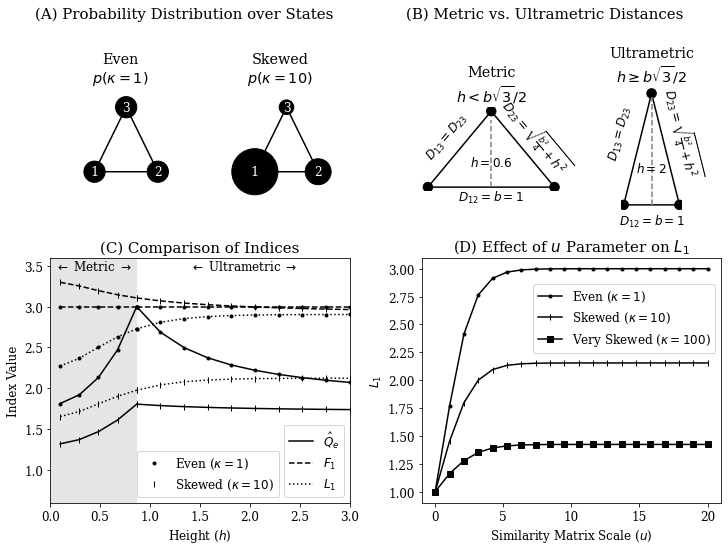

In [6]:
def triangle(h, b=1):
    """ Generates points of a triangle with height h and base b """ 
    points = np.array([[-b/2,0], [b/2,0], [0, h]])
    vertices = (points[:,0], points[:,1])
    edges = np.vstack((points, np.array([[-b/2,0]])))
    edges = (edges[:,0], edges[:,1])
    return vertices, edges

V, E = triangle(1)
fig = plt.figure(figsize=(10, 7), constrained_layout=True)
gs = fig.add_gridspec(3, 4)
ax = [
    [fig.add_subplot(gs[0, i]) for i in range(4)],
    [fig.add_subplot(gs[1:3, :2]), fig.add_subplot(gs[1:3, 2:])]
]

# PANEL A: SKEWNESS DEMONSTRATION
skewlab = ["Even", "Skewed"]
for i, kappa in enumerate([1, 10]):
    p = p_skew(kappa)
    ax[0][i].set_title(skewlab[i] + "\n" + r"$p(\kappa=%s)$" %kappa)
    ax[0][i].plot(E[0], E[1], "k");
    ax[0][i].scatter(V[0], V[1], facecolor="k", edgecolor="k", s=150/p_skew(kappa));
    ax[0][i].text(V[0][0], V[1][0], s="1", color="white", fontsize=13, 
                  horizontalalignment="center", verticalalignment="center");
    ax[0][i].text(V[0][1], V[1][1], s="2", color="white", fontsize=12, 
                  horizontalalignment="center", verticalalignment="center");
    ax[0][i].text(V[0][2], V[1][2], s="3", color="white", fontsize=12, 
                  horizontalalignment="center", verticalalignment="center");
    ax[0][i].set_xlim([-1.2, 1]);
    ax[0][i].set_ylim([-0.6, 1.3]);
    ax[0][i].axis("off");

# PANEL B: ULTRAMETRIC DISTANCE DEMONSTRATION
for i, h in enumerate([0.6, 2]):
    V, E = triangle(h)
    if h >= np.sqrt(3)/2: 
        facecolor = "white"
        symb = "\geq"
        lab = "Ultrametric"
    else: 
        facecolor = "white"
        symb = "<"
        lab= "Metric"
    ax[0][2+i].set_title(lab + "\n" + r"$h %s b\sqrt{3}/2$" %symb)
    ax[0][2+i].fill_between(E[0], E[1], facecolor=facecolor, alpha=0.2);
    ax[0][2+i].plot(E[0], E[1], "k");
    #ax[1][i].plot(V[0][:2], V[1][:2]-0.1, c="gray", ls="--");
    ax[0][2+i].plot([0, 0], [0, V[1][2]-0.07], c="gray", ls="--");
    ax[0][2+i].scatter(V[0], V[1], facecolor="k", edgecolor="k", s=30/p_skew(1));

    ax[0][2+i].text(0, -0.08 - (4*i*0.05), s=r"$D_{12}=b=1$", horizontalalignment="center", verticalalignment="center");
    ax[0][2+i].text(0.35+0.2*i, h/2+0.1+0.2*i, s=r"$D_{23}=\sqrt{\frac{b^2}{4} + h^2}$", 
                    horizontalalignment="center", verticalalignment="center", 
                    rotation=-np.rad2deg(np.arctan(h/0.5)));
    ax[0][2+i].text(-0.35-0.2*i, h/2+0.1 + 0.2*i, s=r"$D_{13}=D_{23}$", 
                    horizontalalignment="center", verticalalignment="center", 
                    rotation=np.rad2deg(np.arctan(h/0.5))); 
    ax[0][2+i].text(0, V[1][2]/3, s=r"$h=%s$" %h, horizontalalignment="center", verticalalignment="center");

    ax[0][2+i].set_aspect(1);
    ax[0][2+i].axis("off");

plt.figtext(0.25, 1.05, "(A) Probability Distribution over States", 
            horizontalalignment="center",
            fontsize=15)
plt.figtext(0.75, 1.05, "(B) Metric vs. Ultrametric Distances", 
            horizontalalignment="center",
            fontsize=15)

# PANEL C: INDEX COMPARISON
c = ["k"]*6 #["blue", "red", "green", "cyan", "purple"]
ls = ["-", "--", ":", "-."]
ms = [".", "|", "s"]
arng = np.array([1, 10])
hrng0 = np.linspace(0.1, np.sqrt(3)/2-0.0001, 5)
hrng1 = np.linspace(np.sqrt(3)/2+0.0001, 3, 10)

ax[1][0].set_title("(C) Comparison of Indices", fontsize=15)
ax[1][0].set_ylabel("Index Value")
ax[1][0].set_xlabel(r"Height ($h$)")
ax[1][0].axvspan(0, np.sqrt(3)/2, facecolor="grey", alpha=0.2)
ax[1][0].text(np.sqrt(3)/4, 3.5, s=r"$\leftarrow$ Metric $\rightarrow$", 
        verticalalignment="center",
        horizontalalignment="center")
ax[1][0].text((hrng1.max()-np.sqrt(3)/2)/2 + np.sqrt(3)/2, 3.5, 
        s=r"$\leftarrow$ Ultrametric $\rightarrow$", 
        verticalalignment="center",
        horizontalalignment="center")
for i,a in enumerate(arng):
    # NeqRQE
    y_qneq_m = [Qneq(a, h) for h in hrng0]
    y_qneq_um = [Qneq(a, h) for h in hrng1]
    ax[1][0].plot(hrng0, y_qneq_m, marker=ms[i], c=c[0], ls="-") 
    ax[1][0].plot(hrng1, y_qneq_um, marker=ms[i], c=c[0], ls="-") 

    # FHN
    y_fhn_m = [Fq(a, h) for h in hrng0]
    y_fhn_um = [Fq(a, h) for h in hrng1]
    ax[1][0].plot(hrng0, y_fhn_m, marker=ms[i], c=c[1], ls="--") 
    ax[1][0].plot(hrng1, y_fhn_um,marker=ms[i], c=c[1], ls="--") 

    # LCI
    y_lci_m = [L(a, h, u=3) for h in hrng0]
    y_lci_um = [L(a, h, u=3) for h in hrng1]
    ax[1][0].plot(hrng0, y_lci_m, marker=ms[i], c=c[2], ls=":") 
    ax[1][0].plot(hrng1, y_lci_um, marker=ms[i], c=c[2], ls=":") 

ax[1][0].set_xlim([0, hrng1.max()])
ax[1][0].set_ylim([0.6, 3.6]);


custom_lines = [
    Line2D([0], [0], color="k", marker=ms[0], lw=0), 
    Line2D([0], [0], color="k", marker=ms[1], lw=0),
    Line2D([0], [0], color="k", ls="-"), 
    Line2D([0], [0], color="k", ls="--"),
    Line2D([0], [0], color="k", ls=":")]
line_labels = [
        r"Even ($\kappa=1$)", 
        r"Skewed ($\kappa=10$)", 
        r"$\hat{Q}_e$", 
        r"$F_1$", 
        r"$L_1$"]

l1 = ax[1][0].legend(custom_lines[:2], line_labels[:2], 
                     loc="lower left",
                     bbox_to_anchor=(0.27, 0, 0.5, 0.5));
l2 = ax[1][0].legend(custom_lines[2:], line_labels[2:], 
                     loc="lower right");
ax[1][0].add_artist(l1);

# PANEL D: EFFECT OF U PARAMETER ON LCI
c = ["blue", "red", "green", "cyan", "purple"]
ls = ["-", "--", ":", "-."]
arng = np.array([1, 10, 100])
urng = np.linspace(0, 20, 20)

ax[1][1].set_title(r"(D) Effect of $u$ Parameter on $L_1$", fontsize=15)
ax[1][1].set_xlabel("Similarity Matrix Scale ($u$)")
ax[1][1].set_ylabel(r"$L_1$")

skew_lab = [
        r"Even ($\kappa=1$)", 
        r"Skewed ($\kappa=10$)", 
        r"Very Skewed ($\kappa=100$)"]
for i,a in enumerate(arng):
    y_m = [L(a, np.sqrt(3)/2, u=u) for u in urng]
    ax[1][1].plot(urng, y_m, c="k", ls="-", marker=ms[i],  label=skew_lab[i])
ax[1][1].legend(bbox_to_anchor=(0.5, 0.5, 0.5, 0.5)) 
plt.savefig("Figure1.pdf", bbox_inches="tight")

---
## Supplemental Code for Section 3.2: _Rényi Heterogeneity on Non-Categorical Representations_

### Figure 2: Difference Between Parametric and Non-Parametric Pooling Distributions

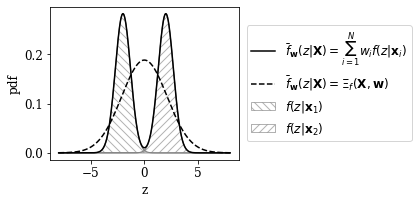

In [7]:
m = np.array([[-2], [2]])
c = np.array([[[1]], [[1]]])*0.5
w = np.array([0.5 ,0.5])

def mvnpdf(x, m, c, w=1):
    if np.ndim(x) == 0:
        out = w*ss.multivariate_normal(m, c).pdf(x)
    else: 
        out = np.array([w*ss.multivariate_normal(m, c).pdf(x_) for x_ in x])
    return out

def mixpdf(x, m=m, c=c, w=w):
    p1 = mvnpdf(x, m=m[0], c=c[0], w=w[0])
    p2 = mvnpdf(x, m=m[1], c=c[1], w=w[1])
    return p1 + p2

def pooledpdf(x, m=m, c=c, w=w):
    M = np.einsum('ij,i->j', m, w)
    C = np.einsum('ijk,i->jk', c, w)
    C += np.einsum('i,ij,ik->jk', w, m, m)
    C -= np.einsum('i,j->ij', M, M)
    mvn = ss.multivariate_normal(M, C)

    if np.ndim(x) == 0:
        out = mvn.pdf(x)
    else: 
        out = np.array([mvn.pdf(x_) for x_ in x])
    return out

# Generate the figure
xrng = np.linspace(-8, 8, 500)
fig, ax = plt.subplots(ncols=1, figsize=(6, 3))
#ax.set_title(r"Pooling Methods for Mixture of 2 Univariate Gaussians")
#ax[1].set_title(r"$\bar{f}_{\mathbf{w}}(z|\mathbf{X}) = \Xi_f\left(\mathbf{X}, \mathbf{w}\right)$")
ax.set_ylabel("pdf")
ax.set_xlabel("z")

ax.plot(xrng, mvnpdf(xrng, m[0], c[0], w[0]), c="gray", ls="-", lw=1)
ax.fill_between(xrng, mvnpdf(xrng, m[0], c[0], w[0]),
                   hatch="\\\\\\", facecolor="white", alpha=0.6,
                   edgecolor="gray", label=r"$f(z|\mathbf{x}_1)$")
ax.plot(xrng, mvnpdf(xrng, m[1], c[1], w[1]), c="gray", ls="-", lw=1)
ax.fill_between(xrng, mvnpdf(xrng, m[1], c[1], w[1]),
                   hatch="///", facecolor="white", alpha=0.6,
                   edgecolor="gray", label=r"$f(z|\mathbf{x}_2)$")
ax.plot(xrng, mixpdf(xrng, m, c, w), c="k", label=r"$\bar{f}_{\mathbf{w}}(z|\mathbf{X}) = \sum_{i=1}^N w_i f(z|\mathbf{x}_i)$")
ax.plot(xrng, pooledpdf(xrng, m, c, w), c="k", ls="--", label=r"$\bar{f}_{\mathbf{w}}(z|\mathbf{X}) = \Xi_f\left(\mathbf{X}, \mathbf{w}\right)$")
ax.legend(loc="center left", bbox_to_anchor=(1.01, 0.25 ,0.5, 0.5), fontsize=12)
plt.tight_layout()
plt.savefig("Figure3.pdf", bbox_inches="tight")

---
## Supplemental Code for Section 4.1: _Comparison of Heterogeneity Indices Under a Mixture of Beta Distributions_

##### Definitions 

- $\mathcal X = [0, 1]$: Observable space 
- $\mathcal Z = \left\{\mathbf z \in \left\{0, 1\right\}^2:\sum_{i=1}^2 z_i = 1\right\}$: Latent space of one-hot categories
- $x \in \mathcal X$: Observation
- $\mathbf z = (z_1, z_2)^\top \in \mathcal Z$: Latent categorical representation

##### Prior Distribution 

$$
p_c(\mathbf z) = \left(1-c, c\right)^\top,\;\; 0\leq c \leq 1
$$

##### Likelihood

$$
p_{a, b}(x|\mathbf z) = \left(\frac{x^{a - 1}\left(1-x\right)^{b - 1}}{\mathrm{B}(a, b)}, \frac{x^{b - 1}\left(1-x\right)^{a - 1}}{\mathrm{B}(b, a)}\right)^\top
$$

##### Joint 

$$
p_{a, b, c}(x, \mathbf z) = \left((1-c)\frac{x^{a - 1}\left(1-x\right)^{b - 1}}{\mathrm{B}(a, b)}, c\frac{x^{b - 1}\left(1-x\right)^{a - 1}}{\mathrm{B}(b, a)}\right)^\top
$$

##### Marginal 

$$
p_{a, b, c}(x) = (1-c)\frac{x^{a - 1}\left(1-x\right)^{b - 1}}{\mathrm{B}(a, b)}+ c\frac{x^{b - 1}\left(1-x\right)^{a - 1}}{\mathrm{B}(b, a)}
$$

##### Marginal Survival 

Let $I_{x}(a, b)$ be the regularized incomplete beta function.

$$
\psi_{a,b,c}(x) = (1 - c) I_{x}(a, b) + c I_{x}(b, a),
$$

##### Posterior 

$$
p_{a,b,c}(\mathbf z|x) = \left[ \left(1-\frac{c(x^{-1} - 1)^{a-b}}{c-1}\right)^{-1}, \left(1-\frac{(c-1)(x^{-1} - 1)^{b-a}}{c}\right)^{-1} \right]^\top
$$

##### Optimal Decision Threshold 

$$
\tau(a, b, c) = \left\{\begin{array}{ll}
    \left[
    \left(c^{-1} -1 \right)^\frac{1}{2(a-b)}
    \left(1-c\right)^\frac{1}{2(a-b)}
    c^{-\frac{1}{2(a-b)}} + 1
    \right]^{-1} & a-b \neq 0 \\
     0 & \left((a > b) \wedge (c < \frac{1}{2})\right) \vee \left((b > a)  \wedge (c > \frac{1}{2})\right) \\
     1 & \text{Otherwise}
    \end{array}\right.
$$

In [0]:
def tau(a,b,c):
    """ Optimal threshold for the mixture of 2 beta distributions """
    if a != b:
        m = 1/(2*(a-b))
        out = 1/(((1/c-1)**m)*((1-c)**m)*(c**(-m))+1)
    elif np.logical_or(np.logical_and(a > b, c<0.5), np.logical_and(b>a, c>0.5)):
        out = 0
    else: 
        out = 1
    return out

def marginal_sf(a,b,c,x):
    A = (1-c)*BetaRegularized(x, 1, a, b)
    B = c*BetaRegularized(x, 1, b, a)
    return A + B

class BetaMixtureModel(object):
    def __init__(self, a, b, c=0.5, rng=np.random.RandomState()):
        self.a = a; self.b = b; self.c = c
        self.c_ = np.array([1-c, c])
        self.r = c/(c-1)
        self.l_ = [ss.beta(a, b), ss.beta(b, a)]
        self.rng = rng

        # Optimal Threshold
        self.thresh_ = tau(self.a, self.b, self.c)

    def compute_threshold(self):
        return tau(self.a, self.b, self.c)

    def prior(self, z=None):
        if z is not None: 
            out = self.c_@z 
        else: 
            out = self.c_
        return out
    
    def likelihood(self, x, z=None):
        if np.ndim(x) == 0:
            out = np.array([L.pdf(x) for L in self.l_])
        else: 
            out = np.stack([L.pdf(x) for L in self.l_]).T
        if z is not None: 
            out = out@z
        return out

    def joint(self, x):
        if np.ndim(x) == 0:
            out = self.likelihood(x)*self.prior()
        else: 
            n = x.shape[0]
            out = self.likelihood(x)*np.tile(self.c_, [n, 1])
        return out
    
    def marginal(self, x):
        out = self.likelihood(x)@self.prior()
        return out

    def sample_prior(self, n):
        return self.rng.multinomial(1, self.c_, size=n)
    
    def sample_likelihood(self, n):
        out = np.stack([L.rvs(size=n,random_state=self.rng) for L in self.l_]).T
        return out

    def sample(self, n):
        return np.sum(self.sample_likelihood(n)*self.sample_prior(n), axis=1)

    def posterior(self, x):
        y = (1/x) - 1
        pz0 = 1/(1-self.r*(y**(self.a - self.b)))
        pz1 = 1/(1-(y**(self.b-self.a))/self.r)
        return np.hstack((pz0[:,None], pz1[:,None]))

    def sf(self, x):
        if x == "opt":
            x = self.thresh_
        return marginal_sf(self.a,self.b,self.c,x)

### Rényi Heterogeneity Under the BMM

In [0]:
def bmmrenyi(a,b,c,x,q=1):
    """ R\'enyi heterogeneity for the deterministic model in the BMM example """
    p = marginal_sf(a,b,c,x)
    p = np.array(mp.matrix([1-p, p]).tolist(), dtype=np.float)
    if np.any(p == 0):
        out = 1
    elif q == 0:
        out = np.sum(p>0)
    elif q == 1: 
        out = np.exp(-np.sum(p*np.log(p)))
    elif q == np.inf:
        out = 1/np.max(p)
    else: 
        out = np.sum(p**q)**(1/(1-q))
    return out 

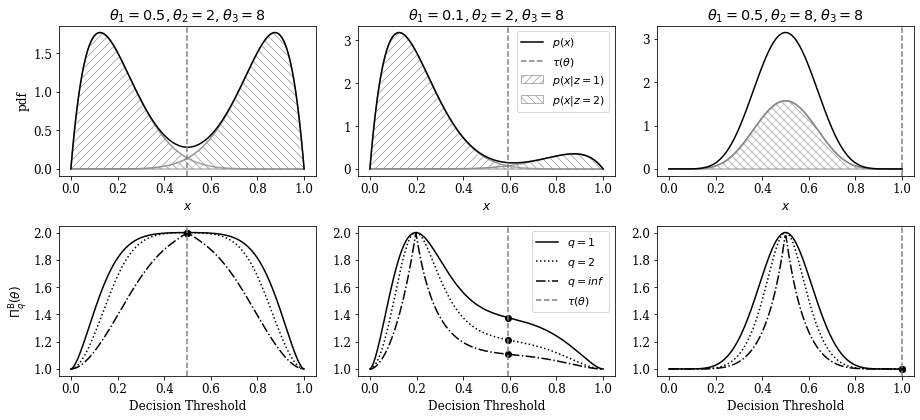

In [10]:
def plot_density(x, y, ax, 
                 hatch="///", 
                 label=None,
                 ec="gray", 
                 fc="white", 
                 alpha=0.6):
    ax.plot(x, y, c=ec, alpha=alpha)
    ax.fill_between(x, y, hatch=hatch, 
                    facecolor=fc, edgecolor=ec, 
                    alpha=alpha, label=label)
    return ax

xrng = np.linspace(0, 1, 250)

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(13, 6))
alphas = [2,2,8]; betas = [8,8,8]; cs = [0.5, 0.1, 0.5]
for i in range(len(alphas)):
    bmm = BetaMixtureModel(alphas[i],betas[i], cs[i])
    p_joint = bmm.joint(xrng)
    p_marginal = bmm.marginal(xrng)
    ax[0,i].set_title(r"$\theta_1=%s, \theta_2=%s, \theta_3=%s$" %(
        cs[i], alphas[i], betas[i]))
    ax[0,i].set_xlabel(r"$x$")
    ax[1,i].set_xlabel(r"Decision Threshold")
    if i == 0:
        ax[0,i].set_ylabel("pdf")
        ax[1,i].set_ylabel(r"$\Pi_q^{\mathrm{B}}(\theta)$")

    ax[0,i] = plot_density(xrng, p_joint[:,0], ax[0,i], "///", r"$p(x|z=1)$")
    ax[0,i] = plot_density(xrng, p_joint[:,1], ax[0,i], "\\\\\\", r"$p(x|z=2)$")
    ax[0,i].plot(xrng, p_marginal, c="k", label=r"$p(x)$")
    ax[0,i].axvline(bmm.thresh_, c="gray",ls="--",label=r"$\tau(\theta)$")

    lstyles = ["-", ":", "-."]
    for j,q in enumerate([1, 2, np.inf]):
        R = np.array([bmmrenyi(alphas[i], betas[i], cs[i], x, q=q) for x in xrng])
        ax[1,i].plot(xrng, R, ls=lstyles[j], c="k", label=r"$q=%s$" %(q))
        ax[1,i].scatter(tau(alphas[i], betas[i], cs[i]), 
                        bmmrenyi(alphas[i], 
                                 betas[i], 
                                 cs[i], 
                                 tau(alphas[i], betas[i], cs[i]), q=q), 
                        facecolor="k")
    ax[1,i].axvline(tau(alphas[i], betas[i], cs[i]), ls="--", c="gray", 
                    label=r"$\tau(\theta)$")

ax[0,1].legend(fontsize=11)
ax[1,1].legend(fontsize=11)
plt.tight_layout()
plt.savefig("Figure4.pdf", bbox_inches="tight")

### Closed-Form Expressions for Classical Indices

To compute the numbers equivalent RQE $\hat{Q}_e$, the functional Hill numbers $F_q$, and the Leinster-Cobbold index $L_q$ under the beta mixture model, we must derive an analytical expression for the distance matrix. This involves the following integral:

\begin{equation}
    d(x,y) = \int_0^1 \int_0^1 |x-y| f(x) g(y)\ \mathrm d x\ \mathrm d y,
\end{equation}

 where $f(x) = \mathrm{Beta}_{\alpha, \beta}(x)$ and $g(y) = \mathrm{Beta}_{\beta,\alpha}(y)$. 

This is as follows: 

\begin{equation}
    \mathbf D(\alpha_1, \beta_1, \alpha_2, \beta_2) = \left(\begin{array}{cc}
    d(x,x) & d(x,y) \\
    d(y,x) & d(y,y)
    \end{array}\right),
\end{equation}

where 

\begin{equation}
d(x,y) = - \langle y \rangle
    +  \eta
    \left(\Phi_a - \alpha_1 \Phi_b \right) \langle x \rangle,
\end{equation}

\noindent where

\begin{equation}
    \eta = \frac{2 \Gamma(\alpha_1) \Gamma(\beta_2) \Gamma(\alpha_1 + \alpha_2 + 1)}{B(\alpha_1, \beta_1)B(\alpha_2, \beta_2)},
\end{equation}

$$
\langle y \rangle = \frac{\alpha_2}{\alpha_2 + \beta_2}
$$

$$
\langle x \rangle = \frac{\alpha_1}{\alpha_1 + \beta_1}
$$

\begin{equation}
    \Phi_a = \tilde{F}_{3,2}\left[\begin{array}{c}
\alpha_1, \alpha_1 + \alpha_2 + 1, 1-\beta_1 \\
\alpha_1 + 1, \alpha_1 + \alpha_2 + \beta_2 + 1
\end{array}, 1\right]
\end{equation}

\begin{equation}
    \Phi_b = \tilde{F}_{3,2}\left[\begin{array}{c}
\alpha_1 + 1, \alpha_1 + \alpha_2 + 1, 1-\beta_1 \\
\alpha_1 + 2, \alpha_1 + \alpha_2 + \beta_2 + 1
\end{array}, 1\right]
\end{equation}

In [0]:
def eta_scale(a1,b1,a2,b2):
    """ Computes the $\eta$ scaling factor above """ 
    num = 2*gamma(a1)*gamma(b2)*gamma(a1 + a2 + 1)
    denom = beta(a1,b1)*beta(a2,b2)
    return num/denom

def PhiA(a1, b1, a2, b2):
    A1 = a1; A2 = a1 + a2 + 1; A3 = 1-b1
    B1= a1 + 1; B2 = a1+a2+b2+1
    denom = gamma(B1)*gamma(B2)
    return mp.hyp3f2(A1,A2,A3,B1,B2,1)/denom

def PhiB(a1, b1, a2, b2):
    A1 = a1+1; A2 = a1 + a2 + 1; A3 = 1-b1
    B1= a1 + 2; B2 = a1+a2+b2+1
    denom = gamma(B1)*gamma(B2)
    return mp.hyp3f2(A1,A2,A3,B1,B2,1)/denom

def d_beta(a1,b1,a2,b2):
    """ Computes the expected distance between two beta random variables """
    X_mean = a1/(a1+b1)
    Y_mean = a2/(a2+b2) 
    eta = eta_scale(a1,b1,a2,b2)
    phiA = PhiA(a1,b1,a2,b2)
    phiB = PhiB(a1,b1,a2,b2)
    return X_mean - Y_mean + eta*(phiA - a1*phiB)

def Dmtx(a1,b1,a2,b2):
    d11 = d_beta(a1,b1,a1,b1)
    d12 = d_beta(a1,b1,a2,b2)
    d22 = d_beta(a2,b2,a2,b2)
    out = mp.matrix([[d11, d12],[d12, d22]])
    out = np.array(out.tolist(), dtype=np.float)
    return out

def Smtx(a1,b1,a2,b2,u=1):
    D = Dmtx(a1,b1,a2,b2)
    return np.exp(-u*D)

#### Figure 1A: Validation of Analytic Distance Matrix Calculation

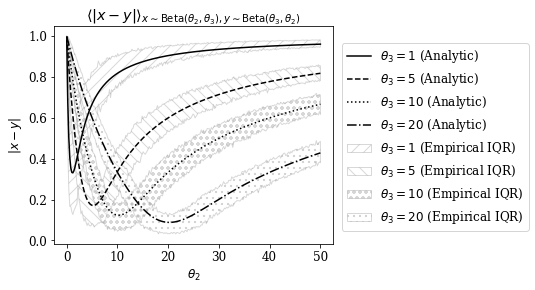

In [12]:
arng = np.linspace(0.01, 50, 250)
brng = [1,5,10,20]
lstyles = ["-", "--", ":", "-."]
hstyles = ["//", "\\\\", "oo", ".."]

fig, ax = plt.subplots(figsize=(5, 4))
for j,b in enumerate(brng):
    d_ = []
    p_ = []
    for a in arng:
        X = BetaMixtureModel(a,b).sample_likelihood(500)
        p_.append(np.percentile(np.abs(X[:,1]-X[:,0]), [25, 75]))
        d_.append(d_beta(a, b, b, a))
    d_ = np.array(d_)
    p_ = np.stack(p_)
    ax.plot(arng, d_, c="k", ls=lstyles[j], label=r"$\theta_3=%s$ (Analytic)" %b)
    ax.fill_between(arng, p_[:,0], p_[:,1], 
                     hatch=hstyles[j], facecolor="white", 
                     edgecolor="gray", alpha=0.3, label=r"$\theta_3=%s$ (Empirical IQR)" %b)
ax.set_xlabel(r"$\theta_2$")
ax.set_ylabel(r"$|x-y|$")
ax.set_title(r"$\langle |x-y| \rangle_{x\sim \mathrm{Beta}(\theta_2, \theta_3), y \sim \mathrm{Beta}(\theta_3,\theta_2)}$")
ax.legend(bbox_to_anchor=(1.01, 0.45, 0.5, 0.5))
plt.savefig("Figure1A.pdf", bbox_inches="tight")

### Create Analytic Functions

#### Numbers Equivalent RQE

In [0]:
def scale_dmtx(D):
    if np.all(np.equal(D, np.max(D))):
        D = (-1*(2*np.eye(2) - 1) + 1)/2
    else: 
        dmin = np.min(D)
        dmax = np.max(D)
        D = (D-dmin)/(dmax-dmin)
    return D 

def scale_smtx(S):
    if np.all(np.equal(S, np.max(S))):
        S = np.eye(2)
    else: 
        smin = np.min(S)
        smax = np.max(S)
        S = (S-smin)/(smax-smin)
    return S 

def neqrqe(a1,b1,a2,b2,c):
    """ Numbers Equivalent Quadratic Entropy """ 
    p = np.array([1-c, c])
    D = Dmtx(a1, b1, a2, b2)
    if np.all(np.equal(D, np.max(D))):
        out = 1/np.sum(p*p)
    else: 
        D = scale_dmtx(D)
        out = 1/(1-np.einsum('i,ij,j->', p, D, p))
    return out

#### Functional Hill Numbers

In [0]:
def fhn(a1, b1, a2, b2, c, q=1):
    """ Functional Hill Numbers """
    p = np.array([1-c, c])
    pp = np.einsum('i,j->ij', p, p)
    D = Dmtx(a1,b1,a2,b2) 
    Dpp = D*pp
    if q == 1:
        out = np.exp(-0.5*np.sum((Dpp/np.sum(Dpp))*np.log(pp)))
    else: 
        out = np.sum((D*(pp**q)))/np.sum(Dpp)
        out = out**(1/(2*(1-q)))
    return out

#### Leinster Cobbold Index

In [0]:
def lci(a1, b1, a2, b2, c, q=1, u=1):
    p = np.array([1-c, c])
    #D = scale_dmtx(Dmtx(a1, b1, a2, b2))
    #S = np.exp(-u*D)
    S = Smtx(a1, b1, a2, b2)
    p_ = np.einsum('ij,j->i', S, p)
    if q == 1: 
        out = 1/np.prod(p_**p)
    else: 
        out = np.sum(p*(p_**(q-1)))**(1/(1-q))
    return out


### Run Comparisons

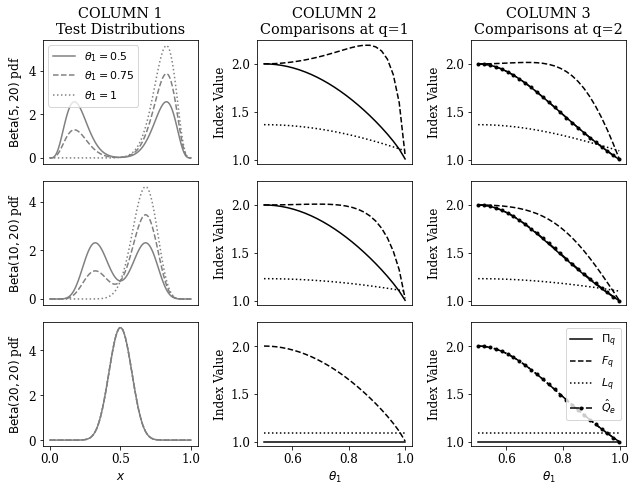

In [16]:
b = 20
crng = np.linspace(0.5,0.999,25)
xrng = np.linspace(0,1,100)
arng = [5, 10, 20]
qrng = [1,2]
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9, 7))
ax[0,0].set_title("COLUMN 1\nTest Distributions")
ax[0,1].set_title("COLUMN 2\nComparisons at q=1")
ax[0,2].set_title("COLUMN 3\nComparisons at q=2")
for i,a in enumerate(arng):
    if i == 2: 
        ax[i,0].set_xlabel(r"$x$")
        for j in range(1,3):
            ax[i,j].set_xlabel(r"$\theta_1$")
    else:
        for j in range(3):
            ax[i,j].xaxis.set_visible(False)
    ax[i,0].set_ylabel(r"$\mathrm{Beta}(%s,%s)$ pdf" %(a,b))
    ax[i,0].plot(xrng, BetaMixtureModel(a,b,0.5).marginal(xrng), c="gray", ls=lstyles[0], label=r"$\theta_1=0.5$")
    ax[i,0].plot(xrng, BetaMixtureModel(a,b,0.75).marginal(xrng), c="gray", ls=lstyles[1], label=r"$\theta_1=0.75$")
    ax[i,0].plot(xrng, BetaMixtureModel(a,b,0.9999).marginal(xrng), c="gray", ls=lstyles[2], label=r"$\theta_1=1$")

    for j in range(1,3):
        ax[i,j].set_ylim([0.96, 2.25])
        ax[i, j].set_ylabel("Index Value")
        #ax[i,j].set_xlim([0, 1])
        #ax[i,j].fill_between(np.linspace(0.5, 1, 100),np.ones(100), np.ones(100)*2, edgecolor="gray", facecolor="white", alpha=0.2, hatch="..")
    
    R1_ = np.array([bmmrenyi(a,b, c, tau(a, b, c), q=1) for c in crng])
    F1_ = np.array([fhn(a,b,b,a,c,q=1) for c in crng])
    L11_ = np.array([lci(a,b,b,a,c,q=1, u=1) for c in crng])
    ax[i,1].plot(crng, R1_, c="k", ls=lstyles[0])
    ax[i,1].plot(crng, F1_, c="k", ls=lstyles[1])
    ax[i,1].plot(crng, L11_, c="k", ls=lstyles[2])

    R2_ = np.array([bmmrenyi(a,b, c, tau(a, b, c), q=2) for c in crng])
    F2_ = np.array([fhn(a,b,b,a,c,q=2) for c in crng])
    L21_ = np.array([lci(a,b,b,a,c,q=2, u=1) for c in crng])
    Q_ = np.array([neqrqe(a,b,b,a,c) for c in crng])
    ax[i,2].plot(crng, R2_, c="k", ls=lstyles[0], label=r"$\Pi_q$")
    ax[i,2].plot(crng, F2_, c="k", ls=lstyles[1], label=r"$F_q$")
    ax[i,2].plot(crng, L21_, c="k", ls=lstyles[2], label=r"$L_q$")
    ax[i,2].plot(crng, Q_, c="k", ls=lstyles[3], marker=".", label=r"$\hat{Q}_e$")
ax[0,0].legend(fontsize=11)
ax[2,2].legend(ncol=1, fontsize=11)
plt.tight_layout()
plt.savefig("Figure5.pdf", bbox_inches="tight")

---
## Supplemental Code for Section 4.2: _Representational Rényi Heterogeneity is Scalable to Deep Learning Models_

The deep learning aspect of this analysis is largely based on code provided by the Smart Geometry Processing Group at University College London: https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb

In [0]:
# REGISTER THE TURBO COLORMAP
# Registering the "turbo" colormap
turbo_data = np.array([[0.18995,0.07176,0.23217],[0.19483,0.08339,0.26149],[0.19956,0.09498,0.29024],[0.20415,0.10652,0.31844],[0.20860,0.11802,0.34607],[0.21291,0.12947,0.37314],[0.21708,0.14087,0.39964],[0.22111,0.15223,0.42558],[0.22500,0.16354,0.45096],[0.22875,0.17481,0.47578],[0.23236,0.18603,0.50004],[0.23582,0.19720,0.52373],[0.23915,0.20833,0.54686],[0.24234,0.21941,0.56942],[0.24539,0.23044,0.59142],[0.24830,0.24143,0.61286],[0.25107,0.25237,0.63374],[0.25369,0.26327,0.65406],[0.25618,0.27412,0.67381],[0.25853,0.28492,0.69300],[0.26074,0.29568,0.71162],[0.26280,0.30639,0.72968],[0.26473,0.31706,0.74718],[0.26652,0.32768,0.76412],[0.26816,0.33825,0.78050],[0.26967,0.34878,0.79631],[0.27103,0.35926,0.81156],[0.27226,0.36970,0.82624],[0.27334,0.38008,0.84037],[0.27429,0.39043,0.85393],[0.27509,0.40072,0.86692],[0.27576,0.41097,0.87936],[0.27628,0.42118,0.89123],[0.27667,0.43134,0.90254],[0.27691,0.44145,0.91328],[0.27701,0.45152,0.92347],[0.27698,0.46153,0.93309],[0.27680,0.47151,0.94214],[0.27648,0.48144,0.95064],[0.27603,0.49132,0.95857],[0.27543,0.50115,0.96594],[0.27469,0.51094,0.97275],[0.27381,0.52069,0.97899],[0.27273,0.53040,0.98461],[0.27106,0.54015,0.98930],[0.26878,0.54995,0.99303],[0.26592,0.55979,0.99583],[0.26252,0.56967,0.99773],[0.25862,0.57958,0.99876],[0.25425,0.58950,0.99896],[0.24946,0.59943,0.99835],[0.24427,0.60937,0.99697],[0.23874,0.61931,0.99485],[0.23288,0.62923,0.99202],[0.22676,0.63913,0.98851],[0.22039,0.64901,0.98436],[0.21382,0.65886,0.97959],[0.20708,0.66866,0.97423],[0.20021,0.67842,0.96833],[0.19326,0.68812,0.96190],[0.18625,0.69775,0.95498],[0.17923,0.70732,0.94761],[0.17223,0.71680,0.93981],[0.16529,0.72620,0.93161],[0.15844,0.73551,0.92305],[0.15173,0.74472,0.91416],[0.14519,0.75381,0.90496],[0.13886,0.76279,0.89550],[0.13278,0.77165,0.88580],[0.12698,0.78037,0.87590],[0.12151,0.78896,0.86581],[0.11639,0.79740,0.85559],[0.11167,0.80569,0.84525],[0.10738,0.81381,0.83484],[0.10357,0.82177,0.82437],[0.10026,0.82955,0.81389],[0.09750,0.83714,0.80342],[0.09532,0.84455,0.79299],[0.09377,0.85175,0.78264],[0.09287,0.85875,0.77240],[0.09267,0.86554,0.76230],[0.09320,0.87211,0.75237],[0.09451,0.87844,0.74265],[0.09662,0.88454,0.73316],[0.09958,0.89040,0.72393],[0.10342,0.89600,0.71500],[0.10815,0.90142,0.70599],[0.11374,0.90673,0.69651],[0.12014,0.91193,0.68660],[0.12733,0.91701,0.67627],[0.13526,0.92197,0.66556],[0.14391,0.92680,0.65448],[0.15323,0.93151,0.64308],[0.16319,0.93609,0.63137],[0.17377,0.94053,0.61938],[0.18491,0.94484,0.60713],[0.19659,0.94901,0.59466],[0.20877,0.95304,0.58199],[0.22142,0.95692,0.56914],[0.23449,0.96065,0.55614],[0.24797,0.96423,0.54303],[0.26180,0.96765,0.52981],[0.27597,0.97092,0.51653],[0.29042,0.97403,0.50321],[0.30513,0.97697,0.48987],[0.32006,0.97974,0.47654],[0.33517,0.98234,0.46325],[0.35043,0.98477,0.45002],[0.36581,0.98702,0.43688],[0.38127,0.98909,0.42386],[0.39678,0.99098,0.41098],[0.41229,0.99268,0.39826],[0.42778,0.99419,0.38575],[0.44321,0.99551,0.37345],[0.45854,0.99663,0.36140],[0.47375,0.99755,0.34963],[0.48879,0.99828,0.33816],[0.50362,0.99879,0.32701],[0.51822,0.99910,0.31622],[0.53255,0.99919,0.30581],[0.54658,0.99907,0.29581],[0.56026,0.99873,0.28623],[0.57357,0.99817,0.27712],[0.58646,0.99739,0.26849],[0.59891,0.99638,0.26038],[0.61088,0.99514,0.25280],[0.62233,0.99366,0.24579],[0.63323,0.99195,0.23937],[0.64362,0.98999,0.23356],[0.65394,0.98775,0.22835],[0.66428,0.98524,0.22370],[0.67462,0.98246,0.21960],[0.68494,0.97941,0.21602],[0.69525,0.97610,0.21294],[0.70553,0.97255,0.21032],[0.71577,0.96875,0.20815],[0.72596,0.96470,0.20640],[0.73610,0.96043,0.20504],[0.74617,0.95593,0.20406],[0.75617,0.95121,0.20343],[0.76608,0.94627,0.20311],[0.77591,0.94113,0.20310],[0.78563,0.93579,0.20336],[0.79524,0.93025,0.20386],[0.80473,0.92452,0.20459],[0.81410,0.91861,0.20552],[0.82333,0.91253,0.20663],[0.83241,0.90627,0.20788],[0.84133,0.89986,0.20926],[0.85010,0.89328,0.21074],[0.85868,0.88655,0.21230],[0.86709,0.87968,0.21391],[0.87530,0.87267,0.21555],[0.88331,0.86553,0.21719],[0.89112,0.85826,0.21880],[0.89870,0.85087,0.22038],[0.90605,0.84337,0.22188],[0.91317,0.83576,0.22328],[0.92004,0.82806,0.22456],[0.92666,0.82025,0.22570],[0.93301,0.81236,0.22667],[0.93909,0.80439,0.22744],[0.94489,0.79634,0.22800],[0.95039,0.78823,0.22831],[0.95560,0.78005,0.22836],[0.96049,0.77181,0.22811],[0.96507,0.76352,0.22754],[0.96931,0.75519,0.22663],[0.97323,0.74682,0.22536],[0.97679,0.73842,0.22369],[0.98000,0.73000,0.22161],[0.98289,0.72140,0.21918],[0.98549,0.71250,0.21650],[0.98781,0.70330,0.21358],[0.98986,0.69382,0.21043],[0.99163,0.68408,0.20706],[0.99314,0.67408,0.20348],[0.99438,0.66386,0.19971],[0.99535,0.65341,0.19577],[0.99607,0.64277,0.19165],[0.99654,0.63193,0.18738],[0.99675,0.62093,0.18297],[0.99672,0.60977,0.17842],[0.99644,0.59846,0.17376],[0.99593,0.58703,0.16899],[0.99517,0.57549,0.16412],[0.99419,0.56386,0.15918],[0.99297,0.55214,0.15417],[0.99153,0.54036,0.14910],[0.98987,0.52854,0.14398],[0.98799,0.51667,0.13883],[0.98590,0.50479,0.13367],[0.98360,0.49291,0.12849],[0.98108,0.48104,0.12332],[0.97837,0.46920,0.11817],[0.97545,0.45740,0.11305],[0.97234,0.44565,0.10797],[0.96904,0.43399,0.10294],[0.96555,0.42241,0.09798],[0.96187,0.41093,0.09310],[0.95801,0.39958,0.08831],[0.95398,0.38836,0.08362],[0.94977,0.37729,0.07905],[0.94538,0.36638,0.07461],[0.94084,0.35566,0.07031],[0.93612,0.34513,0.06616],[0.93125,0.33482,0.06218],[0.92623,0.32473,0.05837],[0.92105,0.31489,0.05475],[0.91572,0.30530,0.05134],[0.91024,0.29599,0.04814],[0.90463,0.28696,0.04516],[0.89888,0.27824,0.04243],[0.89298,0.26981,0.03993],[0.88691,0.26152,0.03753],[0.88066,0.25334,0.03521],[0.87422,0.24526,0.03297],[0.86760,0.23730,0.03082],[0.86079,0.22945,0.02875],[0.85380,0.22170,0.02677],[0.84662,0.21407,0.02487],[0.83926,0.20654,0.02305],[0.83172,0.19912,0.02131],[0.82399,0.19182,0.01966],[0.81608,0.18462,0.01809],[0.80799,0.17753,0.01660],[0.79971,0.17055,0.01520],[0.79125,0.16368,0.01387],[0.78260,0.15693,0.01264],[0.77377,0.15028,0.01148],[0.76476,0.14374,0.01041],[0.75556,0.13731,0.00942],[0.74617,0.13098,0.00851],[0.73661,0.12477,0.00769],[0.72686,0.11867,0.00695],[0.71692,0.11268,0.00629],[0.70680,0.10680,0.00571],[0.69650,0.10102,0.00522],[0.68602,0.09536,0.00481],[0.67535,0.08980,0.00449],[0.66449,0.08436,0.00424],[0.65345,0.07902,0.00408],[0.64223,0.07380,0.00401],[0.63082,0.06868,0.00401],[0.61923,0.06367,0.00410],[0.60746,0.05878,0.00427],[0.59550,0.05399,0.00453],[0.58336,0.04931,0.00486],[0.57103,0.04474,0.00529],[0.55852,0.04028,0.00579],[0.54583,0.03593,0.00638],[0.53295,0.03169,0.00705],[0.51989,0.02756,0.00780],[0.50664,0.02354,0.00863],[0.49321,0.01963,0.00955],[0.47960,0.01583,0.01055]])

def rgb_to_cmap(rgb):
    x = np.linspace(0, 1, len(turbo_data))
    out = {'red':[], 'green': [], 'blue':[]}
    for i, xi in enumerate(x):
        out['red'].append((xi, rgb[i,0], rgb[i,0]))
        out['green'].append((xi, rgb[i,1], rgb[i,1]))
        out['blue'].append((xi, rgb[i,2], rgb[i,2]))
    return out

plt.register_cmap(name='turbo', 
                  data=rgb_to_cmap(turbo_data), 
                  lut=turbo_data.shape[0])

### Load Data

In [0]:
def load_mnist(fpath='./data/MNIST', batch_size=128):
    """ https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb """ 
    ftrans = transforms.Compose([transforms.ToTensor()])
    out = [DataLoader(MNIST(root=fpath, download=True, train=t, transform=ftrans), batch_size=batch_size, shuffle=False) for t in [True, False]]
    return out

train_dataloader, test_dataloader = load_mnist()

# Place into numpy arrays for easier manipulation
traindata = list(train_dataloader)
traindata = [[sample[0].numpy(), sample[1].numpy()] for sample in traindata]
X = np.vstack([sample[0] for sample in traindata])
y = np.hstack([sample[1] for sample in traindata])

## Define the Autoencoder

For our purposes, it will suffice to use a pre-trained model.

In [19]:
latent_dims = 2
num_epochs = 100
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

""" https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb"""
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, 
                                        kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, 
                                        kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) 
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x))
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), 
                                        reduction='sum')
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + variational_beta * kldivergence
    
    
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)


# PRE-TRAINED MODEL
filename = 'vae_2d.pth'

if not os.path.isdir('./pretrained'):
    os.makedirs('./pretrained')
print('downloading ...')
urllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/"+filename, "./pretrained/"+filename)
vae.load_state_dict(torch.load('./pretrained/'+filename))
print('done')

downloading ...
done


## Rényi Heterogeneity Computation for Mixture of Gaussians

Recall that the Rényi heterogeneity for a multivariate Gaussian is defined as 

\begin{equation}
\Pi_q(\boldsymbol\Sigma) = \left\{\begin{array}{ll}
  (2 \pi)^{\frac{n}{2}}  q^{\frac{n}{2(q-1)}} \sqrt{\left|\boldsymbol\Sigma \right|} & q\neq1 \wedge q\neq\infty \wedge q \neq 0\\
(2 \pi e)^{\frac{n}{2}} \sqrt{\left|\boldsymbol\Sigma \right|} & q=1 \\
(2\pi)^{\frac{n}{2}} \sqrt{\left|\boldsymbol\Sigma\right|} & q = \infty \\
\text{Undefined} & q = 0
\end{array}\right.
\end{equation}



In [0]:
def mvn_renyi(C, q=1):
    """ Computes the Rényi heterogeneity for a multivariate Gaussian 
    Arguments: 
        C: `ndarray((n,n))`. Covariance matrix
        q: `0<float`. Order of the heterogeneity
    Returns: 
        `float`
    """
    n = C.shape[0]
    SqrtDetC = np.sqrt(np.linalg.det(C))
    if q == 1: 
        out = (2*np.pi*np.e)**(n/2) * SqrtDetC
    elif q == np.inf: 
        out = (2*np.pi)**(n/2) * SqrtDetC
    elif q!=1 and q!=0 and q!=np.inf:
        out = ((2*np.pi)**(n/2))*(q**(n/(2*(q-1))))*SqrtDetC
    return out 

The heterogeneity of a pooled sample of MVN's is known as the $\gamma$-heterogeneity, and is simply computed by applying the above formula to the pooled covariance matrix, $\tilde{\boldsymbol\Sigma}$. The pooled covariance for a mixture of $n_s$ MVNs is as follows: 

\begin{equation}
    \tilde{\boldsymbol\Sigma} = \left\langle \boldsymbol\Sigma \right\rangle + \left\langle \boldsymbol\mu \boldsymbol\mu^\top \right\rangle - \left\langle \boldsymbol\mu \right\rangle  \left\langle \boldsymbol\mu \right\rangle^\top,
\end{equation}

In [0]:
def pool_covariance(means, covs):
    K = covs.shape[0] 
    p = np.repeat(1/K, K)
    cov_ = np.einsum('ijk,i->jk', covs, p) + np.einsum('ij,ik,i->jk', means, means, p)
    mu_ = np.einsum('ij,i->j', means, p)
    return cov_ - np.einsum('i,j->ij', mu_, mu_)

def scale_to_cov(scales):
    return np.vstack([np.expand_dims(np.diagflat(s), 0) for s in scales])

The $\gamma$-heterogeneity is therefore simply $\Pi_q^{(\gamma)}\left(\tilde{\boldsymbol\Sigma}\right)$.

The $\alpha$-heterogeneity when all examples are equally weighted is 

\begin{equation}
\Pi_q^{(\alpha)} = \left\{\begin{array}{ll}
(2 \pi)^{\frac{n}{2}}  q^{\frac{n}{2(q-1)}} \left(\frac{1}{n_s} \sum_{i=1}^{n_s} \left|\boldsymbol\Sigma_k \right|^{\frac{1-q}{2}} \right)^{\frac{1}{1-q}} & q \neq 0 \wedge q \neq 1 \wedge q \neq \infty \\
(2 \pi e)^{\frac{n}{2}} \prod_{i=1}^{n_s} \left|\boldsymbol\Sigma_k \right|^{\frac{1}{2 n_s}} & q = 1 \\
\text{Undefined} & q = 0 \\
\end{array}\right.
\end{equation}

In [0]:
def mvn_renyi_alpha(C,  q=1):
    """ Computes the alpha-heterogeneity for a Gaussian mixture where each sample has equal weight

    Arguments: 

        cov: `ndarray((nsamples, n, n))`. Covariance matrices 
        q: `0<float`. Order of the heterogeneity metric

    Returns: 

        `float`. The alpha-heterogeneity
    """
    K, n, _ = C.shape
    p = np.repeat(1/K, K)
    if q == 1:
        out = np.exp((n + np.sum(p*np.log(np.linalg.det(2*np.pi*C))))/2)
    elif q!=np.inf and q!=1 and q!=0:
        wbar = (p**q)/np.sum(p**q)
        out = ((2*np.pi)**(n/2))*np.sum(wbar*np.sqrt(np.linalg.det(C)))/(q**(n/2))**(1/(1-q))
    return out


Finally, the $\beta$-heterogeneity is simply the ratio of $\gamma$ and $\alpha$. 

### Experiment A: $\beta$ heterogeneity of each digit class

For each MNIST digit, we compute the $\beta$-heterogeneity, which is the effective number of samples in the digit class. 

In [0]:
gammas = []
alphas = []
betas = []
for i in range(10):
    mu, logvar = vae.encoder(torch.Tensor(X[y == i]).to(device))
    loc = mu.cpu().detach().numpy()
    scale = logvar.exp().cpu().detach().numpy()
    cov = scale_to_cov(scale)
    gamma = mvn_renyi(pool_covariance(loc, cov), q=1)
    alpha = mvn_renyi_alpha(cov,q=1)
    beta = gamma/alpha
    gammas.append(gamma)
    alphas.append(alpha)
    betas.append(beta)
    

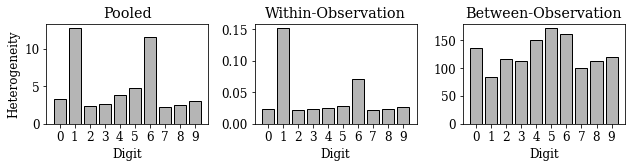

In [28]:
hetvalues = [gammas, alphas, betas]
plotlabels = [r"Pooled", r"Within-Observation", r"Between-Observation"]
fig, ax = plt.subplots(ncols=3, figsize=(9, 2.5))
ax[0].set_ylabel("Heterogeneity")
for i in range(3): 
    ax[i].set_title(plotlabels[i])
    ax[i].set_xlabel("Digit")
    ax[i].set_xticks(np.arange(10))
    ax[i].set_xticklabels(np.arange(10))
    ax[i].bar(np.arange(10), hetvalues[i], 
              facecolor=plt.get_cmap("Greys")(0.4), 
              edgecolor="black")
plt.tight_layout()
plt.savefig("digit-class-heterogeneity.pdf", bbox_inches="tight")

We see that the 1 and 6 digit classes have the highest overall heterogeneity. This may be somewhat surprising, since the `1` class may seem relatively homogeneous. However, we will note that this may be due to the 1's being over-represented in the latent space relative to the effective number of examples (the $\beta$ heterogeneity).

Here, we show the classic filter map of the 2-D latent space of the VAE. 

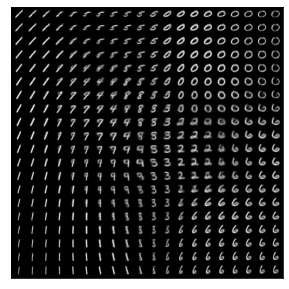

In [25]:
vae.eval()
"""https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb"""
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

bound = 2.5
nsteps = 20 
with torch.no_grad():
    latent_x = np.linspace(-bound,bound,nsteps)
    latent_y = np.linspace(-bound,bound,nsteps)
    latents = torch.FloatTensor(len(latent_x), len(latent_y), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(image_recon.data[:int(nsteps**2)],nsteps,5))
    ax.set_xticks([]); ax.set_xticklabels([])
    ax.set_yticks([]); ax.set_yticklabels([])
    plt.savefig("latent-space-map.pdf", bbox_inches="tight")

We then project the examples onto a latent space complete with $\gamma$-heterogeneity contours.

The $\gamma$-heterogeneity contours were computed by projecting each point in the latent space down into the observable space (through the decoder) then back into the latent space (through the encoder) in order to obtain that point's $\gamma$-heterogeneity.

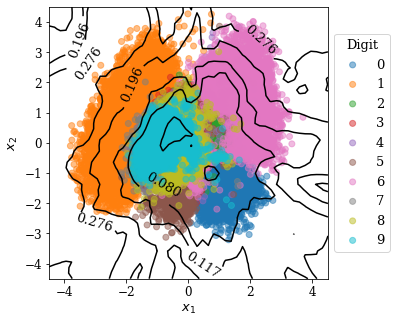

In [26]:
bound = 4.5
nsteps = 50 
with torch.no_grad():
    latent_x = np.linspace(-bound,bound,nsteps)
    latent_y = np.linspace(-bound,bound,nsteps)
    xx, yy = np.meshgrid(latent_x, latent_y)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    mu, logvar = vae.encoder(vae.decoder(latents))
    loc_ = mu.cpu().detach().numpy()
    scale_ = logvar.exp().cpu().detach().numpy()
    gamma = np.array([mvn_renyi(np.diag(cov), q=1) for cov in scale_])

    del(mu); del(logvar);  torch.cuda.empty_cache()

    # Now project the data onto the latent space for plotting 
    Xtensor = torch.Tensor(X).to(device)
    mu, logvar = vae.encoder(Xtensor)
    loc = mu.cpu().detach().numpy()
    scale = logvar.exp().cpu().detach().numpy()
    
    del(Xtensor); torch.cuda.empty_cache()

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlabel(r"$x_1$", fontsize=13)
    ax.set_ylabel(r"$x_2$", fontsize=13)
    cont = ax.contour(xx, yy, gamma.reshape(xx.shape), levels=np.percentile(gamma, np.linspace(1, 75, 5)), colors="black")
    ax.clabel(cont, fontsize=13)
    for i, digit in enumerate(np.unique(y)):
        ax.scatter(loc[y==digit,0], loc[y==digit,1], 
                   c=plt.get_cmap("tab10")(y[y==digit]), 
                   alpha=0.5, 
                   label=str(digit))
    ax.set_xlim([-bound, bound]); ax.set_ylim([-bound, bound])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0, 1, 1), fontsize=13, 
               title="Digit", title_fontsize=13)   
    plt.savefig("latent-space-gamma-heterogeneity.pdf", bbox_inches="tight")

## Does $\beta$-heterogeneity in this context really capture heterogeneity?

The purpose of this aspect of our experiment is to verify (visually) that data sampled from spots with high $\beta$-heterogeneity will be more diverse in their contents. 

For each block of 49 points in the latent space, we reconstructed images, and then projected those images back into the latent space, where we computed the heterogeneity ($\alpha, \beta, \gamma$). We then plotted the image samples from the regions of latent space with the highest and lowest $\beta$-heterogeneity, respectively. 

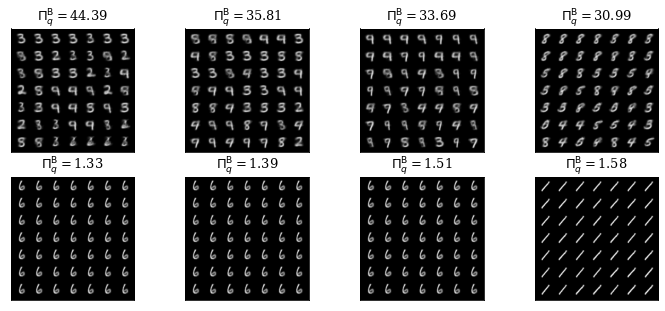

In [27]:
skn = NearestNeighbors(n_neighbors=49, metric="euclidean").fit(loc_)
_, indices = skn.kneighbors(loc_)
gamma = np.array([mvn_renyi(pool_covariance(loc_[idx], scale_to_cov(scale_[idx])), q=1) for idx in indices])
alpha = np.array([mvn_renyi_alpha(scale_to_cov(scale_[idx]), q=1) for idx in indices])  
beta = gamma/alpha

nsamples = 4
fig, ax = plt.subplots(nrows=2, ncols=nsamples, figsize=(12, 5))
beta_sorted_idx = np.argsort(beta)
for i in range(nsamples):
    max_idx = indices[beta_sorted_idx[-(20*i+1)]]
    min_idx = indices[beta_sorted_idx[20*i]]
    
    # Highest beta heterogeneity samples
    Ztensor = torch.Tensor(loc_[max_idx]).to(device)
    images = vae.decoder(Ztensor)
    del(Ztensor); torch.cuda.empty_cache()
    images = images.cpu()
    images = to_img(images)
    np_imagegrid = torchvision.utils.make_grid(images, 7, 7).detach().numpy()
    ax[0,i].set_title(r"$\Pi_q^{\mathrm{B}}=$%0.2f" %beta[beta_sorted_idx[-(20*i+1)]], fontsize=13)
    ax[0,i].imshow(np.transpose(np_imagegrid, (1, 2, 0)))
    ax[0,i].set_xticks([]); ax[0,i].set_xticklabels([])
    ax[0,i].set_yticks([]); ax[0,i].set_yticklabels([])

    # Lowest beta heterogeneity samples
    Ztensor = torch.Tensor(loc_[min_idx]).to(device)
    images = vae.decoder(Ztensor)
    del(Ztensor); torch.cuda.empty_cache()
    images = images.cpu()
    images = to_img(images)
    np_imagegrid = torchvision.utils.make_grid(images, 7, 7).detach().numpy()
    ax[1,i].set_title(r"$\Pi_q^{\mathrm{B}}=$%0.2f" %beta[beta_sorted_idx[20*i]], fontsize=13)
    ax[1,i].imshow(np.transpose(np_imagegrid, (1, 2, 0)))
    ax[1,i].set_xticks([]); ax[1,i].set_xticklabels([])
    ax[1,i].set_yticks([]); ax[1,i].set_yticklabels([])
plt.savefig("beta-heterogeneity-samples.pdf", bbox_inches="tight")